#### train process
1. import csv to df
1. process df to be modelable
  1. add variables
    * dow (cat - 7 vars)
    * hr (cat - 24 vars)
        * pair dow with hr?
    * slow_day (cat - 0, 1)
    * fast_day (cat - 0, 1)
    * L2
        * log L2?
    * google_dist (needs id?)
    * weather (needs datetime?)
1. model
1. use cooksd + fox criterion to identify outliers
1. filter outliers and make new df

encode week-hour (0 - 167)  
implement p_in_manhattan, d_in_manhattan

### * contains point

In [10]:
from shapely.geometry import Polygon
from shapely.geometry import Point
pgon = Polygon([(0, 0), (1, 1), (0, 2), (2, 2), (2, 0)])
print(pgon.area)
pgon.contains(Point(1.001, 1))

3.0


True

## * need to drop outliers (esp. duration)

## * 아래 2칸 실행

In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import sklearn as sk

import matplotlib as mpl
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns
sns.set()
sns.set_style("whitegrid")
sns.set_color_codes()

In [3]:
# 경로 변수 (고정)

dataLoc = '../_data/'

trainfile = 'train_03_997.csv'
old_trainfile = 'train.csv'
kaggle_trainfile = 'train_k.csv'

testfile = 'test_clean.csv'
old_testfile = 'test.csv'

train_171016 = '171016_dow_hr_pas_L2_dur_only.csv'
train_osrm = '../_data/train_with_osrm.csv'
train_osrm_weather = '../_data/train_with_osrm_and_weather.csv'
train_osrm_weather_hourly = '../_data/train_with_osrm_and_weather_hourly.csv'
train_dropped_nan_fixed = '../_data/train__dropped__no_disaster_nan_fixed.csv'
train_added_airps = '../_data/train__dropped__lnglat_saved__airports__no_disaster.csv'
train_added_airps_cleaned = '../_data/train__dropped__cleaned__airports__no_disaster.csv'
train_added_airps_disas_cleaned = '../_data/train__dropped__cleaned__eval__airports__disaster.csv'
train_added_weekhr = 'train__dropped__cleaned__eval__a_d_weekhour.csv'
train_added_manh = '../_data/train__dropped__air_bliz_weekhr_manh.csv'
train_all_vars_rough = '../_data/train__all_vars__rough.csv'
train_latest = train_all_vars_rough

## `train_latest` (전처리 전)

In [2]:
pd.options.display.max_columns = 40

In [4]:
# train_with_osrm_and_weather.csv
df_train = pd.read_csv(dataLoc + train_latest)
df_train.head()

,is_hol,blizz,m_d,dow,hr,weekhour,L2,pas_cnt,p_MANH,d_MANH,...,day_rainfall,day_snowfall,day_snowdepth,hr_temp,hr_humid,hr_dewpt,hr_windspeed,hr_gustspeed,hr_precip,dur
0,False,0,430,Saturday,23,143,0.069424,1,True,False,...,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1454
1,False,0,430,Saturday,23,143,0.057791,1,False,True,...,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1409
2,False,0,430,Saturday,23,143,0.066698,2,True,True,...,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1081
3,False,0,430,Saturday,23,143,0.018223,1,True,True,...,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,800
4,False,0,430,Saturday,23,143,0.027198,1,True,True,...,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1151


In [6]:
df_train.loc[::1000].shape

(684, 27)

In [14]:
df_sample = df_train.loc[::300].copy()

In [15]:
df_sample.head()

,is_hol,blizz,m_d,dow,hr,weekhour,L2,pas_cnt,p_MANH,d_MANH,...,day_rainfall,day_snowfall,day_snowdepth,hr_temp,hr_humid,hr_dewpt,hr_windspeed,hr_gustspeed,hr_precip,dur
0,False,0,430,Saturday,23,143,0.069424,1,True,False,...,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1454
300,False,0,430,Saturday,23,143,0.020399,1,True,True,...,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,419
600,False,0,430,Saturday,22,142,0.072582,1,True,True,...,0.0,0.0,0.0,11.1,0.53,1.7,5.6,0.0,0.0,1471
900,False,0,430,Saturday,21,141,0.009660,1,True,True,...,0.0,0.0,0.0,11.7,0.47,0.6,11.1,0.0,0.0,290
1200,False,0,430,Saturday,20,140,0.015175,1,True,True,...,0.0,0.0,0.0,12.8,0.40,-0.6,7.4,0.0,0.0,578


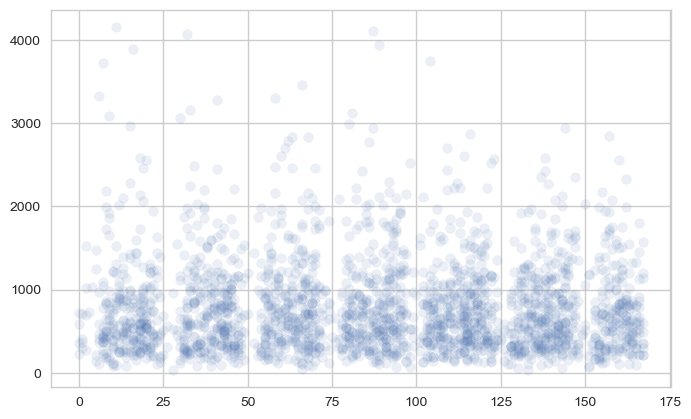

In [16]:
plt.scatter(df_sample['weekhour'], df_sample['dur'], alpha=0.1)
plt.show()

In [9]:
df_train.to_csv('../_data/train__all_vars__rough.csv', index=False)
print('done')

done


In [5]:
df_copy = df_train.copy()

In [6]:
def poly_string(var_, deg):
    poly_sum = 'scale(x)'
    for pwr in range(2, deg+1):
        poly_sum += ' + scale(I({}**{}))'.format(var_, pwr)
    return poly_sum

poly_string('weekhour', 4)
  

'scale(x) + scale(I(weekhour**2)) + scale(I(weekhour**3)) + scale(I(weekhour**4))'

In [8]:
quant_vars = [['blizz', 1],
              ['weekhour', 1],
              ['total_dist', 1],
              ['day_max_temp', 1],
              ['day_rainfall', 1],
              ['day_snowfall', 1],
              ['day_snowdepth', 1],
              ['hr_temp', 1],
              ['hr_humid', 1],
              ['hr_windspeed', 1]]


cat_vars = [['is_hol', 1],
            ['p_MANH', 1],
            ['d_MANH', 1],
            ['p_JFK', 1],
            ['p_LGA', 1],
            ['d_JFK', 1],
            ['d_LGA', 1]]

In [9]:
def set_degree(var_, deg, pairs):
    pairs = dict(pairs)
    pairs[var_] = deg
    return list(pairs.items())

set_degree('weekhour', 3, quant_vars)

[('blizz', 1),
 ('weekhour', 3),
 ('total_dist', 1),
 ('day_max_temp', 1),
 ('day_rainfall', 1),
 ('day_snowfall', 1),
 ('day_snowdepth', 1),
 ('hr_temp', 1),
 ('hr_humid', 1),
 ('hr_windspeed', 1)]

In [10]:
def poly_string(var_, deg, scale_=True):
    
    poly_sum = 'scale({})'.format(var_) if scale_ else var_
    for pwr in range(2, deg+1):
        nth_deg = ' + scale(I({}**{}))'.format(var_, pwr) if scale_\
                  else ' + I({}**{})'.format(var_, pwr)
        poly_sum += nth_deg
    return poly_sum

print(poly_string('aaa', 12, True))
print(poly_string('aaa', 12, False))

scale(aaa) + scale(I(aaa**2)) + scale(I(aaa**3)) + scale(I(aaa**4)) + scale(I(aaa**5)) + scale(I(aaa**6)) + scale(I(aaa**7)) + scale(I(aaa**8)) + scale(I(aaa**9)) + scale(I(aaa**10)) + scale(I(aaa**11)) + scale(I(aaa**12))
aaa + I(aaa**2) + I(aaa**3) + I(aaa**4) + I(aaa**5) + I(aaa**6) + I(aaa**7) + I(aaa**8) + I(aaa**9) + I(aaa**10) + I(aaa**11) + I(aaa**12)


In [11]:
#automation of r-style from_formula
def make_formula(df, quant_list, cat_list, y_str, const_=True, scale_=True): 
    scale_st, scale_en = ("scale(", ")") if scale_ else ("", "")    
    constadd = "" if const_ else " - 1"  
    model_str = "{} ~ ".format(y_str)
    
    for i, (col, deg) in enumerate(quant_list):
        if i == 0:
            prefix = ""
        else:
            prefix = " + "
        model_str += prefix + poly_string(col, deg, scale_)
    
    for i, (col, _) in enumerate(cat_list):
        prefix = " + "
        model_str += prefix + "C(" + col + ")"
    model_str += constadd

    return model_str

In [12]:
make_formula(df_copy, quant_vars, cat_vars, 'dur', const_=True, scale_=True)

'dur ~ scale(blizz) + scale(weekhour) + scale(total_dist) + scale(day_max_temp) + scale(day_rainfall) + scale(day_snowfall) + scale(day_snowdepth) + scale(hr_temp) + scale(hr_humid) + scale(hr_windspeed) + C(is_hol) + C(p_MANH) + C(d_MANH) + C(p_JFK) + C(p_LGA) + C(d_JFK) + C(d_LGA)'

In [13]:
def get_results(df, quant_list, cat_list, y_str, const=True, scale_=True, fmla=None):
    if not fmla:
        fmla = make_formula(df, quant_list, cat_list, y_str, const, scale_)
    print(fmla)
    mod = sm.OLS.from_formula(fmla, data=df)
    res = mod.fit()
    return mod, res

ols_vars_orig = [df_copy, quant_vars, cat_vars, 'dur', True, True]
ols_vars = ols_vars_orig

quant_vars = set_degree('blizz', 1, quant_vars)
quant_vars = set_degree('weekhour', 14, quant_vars)
ols_vars = [df_copy, quant_vars, cat_vars, 'dur', True, True]
print(ols_vars[1:])
#mod, res = get_results(*ols_vars)

[[('blizz', 1), ('weekhour', 14), ('total_dist', 1), ('day_max_temp', 1), ('day_rainfall', 1), ('day_snowfall', 1), ('day_snowdepth', 1), ('hr_temp', 1), ('hr_humid', 1), ('hr_windspeed', 1)], [['is_hol', 1], ['p_MANH', 1], ['d_MANH', 1], ['p_JFK', 1], ['p_LGA', 1], ['d_JFK', 1], ['d_LGA', 1]], 'dur', True, True]


In [14]:
quant_vars = set_degree('blizz', 1, quant_vars)
quant_vars = set_degree('weekhour', 1, quant_vars)
ols_vars = [df_copy, quant_vars, cat_vars, 'dur', False, True]

formula = make_formula(*ols_vars)

print(formula)

dur ~ scale(blizz) + scale(weekhour) + scale(total_dist) + scale(day_max_temp) + scale(day_rainfall) + scale(day_snowfall) + scale(day_snowdepth) + scale(hr_temp) + scale(hr_humid) + scale(hr_windspeed) + C(is_hol) + C(p_MANH) + C(d_MANH) + C(p_JFK) + C(p_LGA) + C(d_JFK) + C(d_LGA) - 1


In [15]:


formula = 'dur ~ scale(blizz) + scale(weekhour) + scale(total_dist) + scale(day_max_temp) + scale(day_rainfall) + scale(day_snowfall) + scale(day_snowdepth) + scale(hr_temp) + scale(hr_humid) + scale(hr_windspeed) + C(is_hol) + C(p_MANH)*C(d_MANH) + C(p_JFK) + C(p_LGA) + C(d_JFK) + C(d_LGA) - 1'
print(formula)

dur ~ scale(blizz) + scale(weekhour) + scale(total_dist) + scale(day_max_temp) + scale(day_rainfall) + scale(day_snowfall) + scale(day_snowdepth) + scale(hr_temp) + scale(hr_humid) + scale(hr_windspeed) + C(is_hol) + C(p_MANH)*C(d_MANH) + C(p_JFK) + C(p_LGA) + C(d_JFK) + C(d_LGA) - 1


In [16]:
print(ols_vars[1:])
mod, res = get_results(*ols_vars, formula)
print('done')

[[('blizz', 1), ('weekhour', 1), ('total_dist', 1), ('day_max_temp', 1), ('day_rainfall', 1), ('day_snowfall', 1), ('day_snowdepth', 1), ('hr_temp', 1), ('hr_humid', 1), ('hr_windspeed', 1)], [['is_hol', 1], ['p_MANH', 1], ['d_MANH', 1], ['p_JFK', 1], ['p_LGA', 1], ['d_JFK', 1], ['d_LGA', 1]], 'dur', False, True]
dur ~ scale(blizz) + scale(weekhour) + scale(total_dist) + scale(day_max_temp) + scale(day_rainfall) + scale(day_snowfall) + scale(day_snowdepth) + scale(hr_temp) + scale(hr_humid) + scale(hr_windspeed) + C(is_hol) + C(p_MANH)*C(d_MANH) + C(p_JFK) + C(p_LGA) + C(d_JFK) + C(d_LGA) - 1
done


In [17]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    dur   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.618
Method:                 Least Squares   F-statistic:                 6.137e+04
Date:                Sat, 21 Oct 2017   Prob (F-statistic):               0.00
Time:                        17:15:44   Log-Likelihood:            -4.9791e+06
No. Observations:              683021   AIC:                         9.958e+06
Df Residuals:                  683002   BIC:                         9.959e+06
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
C(is_hol)[False]                      808.6679      1.960    412.629      0.000     804.827     812.509
C(is_hol)[True]                       681.6986      3.535    192.844      0.000     674.770     688.627
C(p_MANH)[T.True]                       1.1983      2.371      0.505      0.613      -3.449       5.845
C(d_MANH)[T.True]                      -3.4760      2.839     -1.224      0.221      -9.040       2.088
C(p_JFK)[T.True]                     -627.7989      4.645   -135.149      0.000    -636.903    -618.694
C(p_LGA)[T.True]                     -111.6683      3.110    -35.904      0.000    -117.764    -105.573
C(d_JFK)[T.True]                     -558.4903      6.779    -82.391      0.000    -571.776    -545.204
C(d_LGA)[T.True]                     -182.0868      4.428    -41.126      0.000    -190.765    -173.409
C(p_MANH)[T.True]:C(d_MANH)[T.True]    -0.6318      3.176     -0.199      0.842      -6.857       5.594
scale(blizz)                           -2.2189      1.317     -1.685      0.092      -4.800       0.363
scale(weekhour)                       -26.2952      0.444    -59.264      0.000     -27.165     -25.426
scale(total_dist)                     500.1556      0.601    832.689      0.000     498.978     501.333
scale(day_max_temp)                   -52.3846      1.074    -48.767      0.000     -54.490     -50.279
scale(day_rainfall)                    -1.2082      0.532     -2.271      0.023      -2.251      -0.165
scale(day_snowfall)                     2.7579      0.655      4.211      0.000       1.474       4.041
scale(day_snowdepth)                   20.8659      1.210     17.240      0.000      18.494      23.238
scale(hr_temp)                         75.8937      1.065     71.286      0.000      73.807      77.980
scale(hr_humid)                       -13.0951      0.496    -26.378      0.000     -14.068     -12.122
scale(hr_windspeed)                    11.1837      0.442     25.316      0.000      10.318      12.050
==============================================================================
Omnibus:                   231048.928   Durbin-Watson:                   1.713
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1653196.281
Skew:                           1.445   Prob(JB):                         0.00
Kurtosis:                      10.052   Cond. No.                         29.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [18]:
sm.stats.anova_lm(res, typ=2)

,sum_sq,df,F,PR(>F)
C(is_hol),2.150919e+10,2.0,85536.007051,0.000000e+00
C(p_MANH),3.616207e+04,1.0,0.287613,5.917545e-01
C(d_MANH),1.227941e+06,1.0,9.766350,1.777424e-03
C(p_JFK),2.296525e+09,1.0,18265.269166,0.000000e+00
C(p_LGA),1.620845e+08,1.0,1289.128952,4.785362e-282
C(d_JFK),8.534926e+08,1.0,6788.200003,0.000000e+00
C(d_LGA),2.126556e+08,1.0,1691.342827,0.000000e+00
C(p_MANH):C(d_MANH),4.974683e+03,1.0,0.039566,8.423319e-01
scale(blizz),3.568182e+05,1.0,2.837931,9.206313e-02
scale(weekhour),4.416036e+08,1.0,3512.266962,0.000000e+00


In [157]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    dur   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.618
Method:                 Least Squares   F-statistic:                 6.904e+04
Date:                Sat, 21 Oct 2017   Prob (F-statistic):               0.00
Time:                        16:41:46   Log-Likelihood:            -4.9791e+06
No. Observations:              683021   AIC:                         9.958e+06
Df Residuals:                  683004   BIC:                         9.959e+06
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                           806.2631      0.455   1773.911      0.000     805.372     807.154
C(is_hol)[T.True]                  -127.0057      3.008    -42.221      0.000    -132.901    -121.110
C(p_JFK)[T.True]                   -627.3598      4.647   -134.993      0.000    -636.468    -618.251
C(d_LGA)[T.True]                   -181.8879      4.428    -41.076      0.000    -190.567    -173.209
C(p_LGA)[T.True]                   -110.7511      3.124    -35.449      0.000    -116.874    -104.628
C(d_JFK)[T.True]                   -554.6552      6.895    -80.439      0.000    -568.170    -541.141
C(p_LGA)[T.True]:C(d_JFK)[T.True]  -110.5649     36.011     -3.070      0.002    -181.144     -39.985
scale(blizz)                         -2.1838      1.317     -1.658      0.097      -4.765       0.398
scale(weekhour)                     -26.2864      0.444    -59.252      0.000     -27.156     -25.417
scale(total_dist)                   500.0534      0.602    831.221      0.000     498.874     501.233
scale(day_max_temp)                 -52.3749      1.074    -48.759      0.000     -54.480     -50.270
scale(day_rainfall)                  -1.2107      0.532     -2.276      0.023      -2.254      -0.168
scale(day_snowfall)                   2.7413      0.655      4.186      0.000       1.458       4.025
scale(day_snowdepth)                 20.8364      1.210     17.217      0.000      18.464      23.208
scale(hr_temp)                       75.8954      1.065     71.288      0.000      73.809      77.982
scale(hr_humid)                     -13.1054      0.496    -26.399      0.000     -14.078     -12.132
scale(hr_windspeed)                  11.1869      0.442     25.323      0.000      10.321      12.053
==============================================================================
Omnibus:                   230994.138   Durbin-Watson:                   1.713
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1652168.781
Skew:                           1.445   Prob(JB):                         0.00
Kurtosis:                      10.050   Cond. No.                         127.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [154]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    dur   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.618
Method:                 Least Squares   F-statistic:                 6.498e+04
Date:                Sat, 21 Oct 2017   Prob (F-statistic):               0.00
Time:                        16:40:11   Log-Likelihood:            -4.9791e+06
No. Observations:              683021   AIC:                         9.958e+06
Df Residuals:                  683003   BIC:                         9.959e+06
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                           806.2619      0.455   1773.463      0.000     805.371     807.153
C(is_hol)[T.True]                  -127.0055      3.008    -42.221      0.000    -132.901    -121.110
C(p_JFK)[T.True]                   -627.2962      4.680   -134.031      0.000    -636.469    -618.123
C(d_LGA)[T.True]                   -181.8216      4.466    -40.716      0.000    -190.574    -173.069
C(p_LGA)[T.True]                   -110.7429      3.125    -35.437      0.000    -116.868    -104.618
C(d_JFK)[T.True]                   -554.6391      6.897    -80.420      0.000    -568.157    -541.122
C(p_JFK)[T.True]:C(d_LGA)[T.True]    -4.1291     35.971     -0.115      0.909     -74.632      66.373
C(p_LGA)[T.True]:C(d_JFK)[T.True]  -110.5760     36.011     -3.071      0.002    -181.156     -39.996
scale(blizz)                         -2.1838      1.317     -1.658      0.097      -4.765       0.398
scale(weekhour)                     -26.2862      0.444    -59.251      0.000     -27.156     -25.417
scale(total_dist)                   500.0497      0.602    830.008      0.000     498.869     501.231
scale(day_max_temp)                 -52.3747      1.074    -48.759      0.000     -54.480     -50.269
scale(day_rainfall)                  -1.2108      0.532     -2.276      0.023      -2.254      -0.168
scale(day_snowfall)                   2.7414      0.655      4.187      0.000       1.458       4.025
scale(day_snowdepth)                 20.8364      1.210     17.217      0.000      18.464      23.208
scale(hr_temp)                       75.8951      1.065     71.287      0.000      73.808      77.982
scale(hr_humid)                     -13.1054      0.496    -26.399      0.000     -14.078     -12.132
scale(hr_windspeed)                  11.1868      0.442     25.323      0.000      10.321      12.053
==============================================================================
Omnibus:                   230992.631   Durbin-Watson:                   1.713
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1652141.422
Skew:                           1.445   Prob(JB):                         0.00
Kurtosis:                      10.050   Cond. No.                         127.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
#dropping outliers by fox_critiria
def dropping_outliers1(x, y):
    x1 = sm.add_constant(x)
    model = sm.OLS(y, x1)
    result = model.fit()
    influence = result.get_influence()
    cooks_d2, pvals = influence.cooks_distance
    fox_cr = 4 / (len(y) - len(x.columns) -1)
    idx = np.where(cooks_d2 > fox_cr)[0]
    x = x.drop(x.index[idx])

In [61]:
  
#     fmla = 'dur ~ scale(blizz) + C(is_hol)\
#                 + scale(weekhour) + scale(I(weekhour**2)) \
#                 + C(p_JFK) + C(p_LGA) + C(d_JFK) + C(d_LGA)\
#                 + scale(total_dist) + scale(day_max_temp) + scale(day_rainfall)\
#                 + scale(day_snowfall) + scale(day_snowdepth) + scale(hr_temp) + scale(hr_humid)\
#                 + scale(hr_windspeed) - 1'

model11 = sm.OLS.from_formula('dur ~ scale(blizz) + C(is_hol)\
                            + scale(weekhour) + scale(I(weekhour**2)) \
                            + C(p_JFK) + C(p_LGA) + C(d_JFK) + C(d_LGA)\
                            + scale(total_dist) + scale(day_max_temp) + scale(day_rainfall)\
                            + scale(day_snowfall) + scale(day_snowdepth) + scale(hr_temp) + scale(hr_humid)\
                            + scale(hr_windspeed) - 1', data=df_copy)
res11 = model11.fit()
res11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    dur   R-squared:                       0.622
Model:                            OLS   Adj. R-squared:                  0.622
Method:                 Least Squares   F-statistic:                 7.020e+04
Date:                Sat, 21 Oct 2017   Prob (F-statistic):               0.00
Time:                        15:09:47   Log-Likelihood:            -4.9756e+06
No. Observations:              683021   AIC:                         9.951e+06
Df Residuals:                  683004   BIC:                         9.951e+06
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
C(is_hol)[False]          805.5286      0.452   1781.544      0.000     804.642     806.415
C(is_hol)[True]           706.3780      2.977    237.258      0.000     700.543     712.213
C(p_JFK)[T.True]         -622.5136      4.622   -134.692      0.000    -631.572    -613.455
C(p_LGA)[T.True]         -107.8115      3.094    -34.840      0.000    -113.877    -101.746
C(d_JFK)[T.True]         -555.3204      6.744    -82.345      0.000    -568.538    -542.103
C(d_LGA)[T.True]         -184.4412      4.405    -41.872      0.000    -193.074    -175.808
scale(blizz)                1.0232      1.311      0.781      0.435      -1.546       3.592
scale(weekhour)           121.9654      1.815     67.191      0.000     118.408     125.523
scale(I(weekhour ** 2))  -151.5933      1.800    -84.201      0.000    -155.122    -148.065
scale(total_dist)         500.3946      0.598    837.386      0.000     499.223     501.566
scale(day_max_temp)       -45.8562      1.071    -42.799      0.000     -47.956     -43.756
scale(day_rainfall)         4.1248      0.533      7.738      0.000       3.080       5.170
scale(day_snowfall)        -1.2134      0.653     -1.858      0.063      -2.493       0.067
scale(day_snowdepth)       21.7291      1.204     18.046      0.000      19.369      24.089
scale(hr_temp)             68.0198      1.063     63.972      0.000      65.936      70.104
scale(hr_humid)           -15.9612      0.495    -32.242      0.000     -16.932     -14.991
scale(hr_windspeed)        12.1105      0.440     27.547      0.000      11.249      12.972
==============================================================================
Omnibus:                   230238.699   Durbin-Watson:                   1.730
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1669770.558
Skew:                           1.435   Prob(JB):                         0.00
Kurtosis:                      10.102   Cond. No.                         24.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [64]:
# def poly_string(var_):
#     'scale'

# def poly_weekhour(deg):
    
#     fmla = 'dur ~ scale(blizz) + C(is_hol)\
#                 + scale(weekhour) + scale(I(weekhour**2)) \
#                 + C(p_JFK) + C(p_LGA) + C(d_JFK) + C(d_LGA)\
#                 + scale(total_dist) + scale(day_max_temp) + scale(day_rainfall)\
#                 + scale(day_snowfall) + scale(day_snowdepth) + scale(hr_temp) + scale(hr_humid)\
#                 + scale(hr_windspeed) - 1'

model11 = sm.OLS.from_formula('dur ~ scale(blizz) + C(is_hol)\
                            + scale(I(weekhour**1)) + scale(I(weekhour**2)) \
                            + C(p_JFK) + C(p_LGA) + C(d_JFK) + C(d_LGA)\
                            + scale(total_dist) + scale(day_max_temp) + scale(day_rainfall)\
                            + scale(day_snowfall) + scale(day_snowdepth) + scale(hr_temp) + scale(hr_humid)\
                            + scale(hr_windspeed) - 1', data=df_copy)
res11 = model11.fit()
res11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    dur   R-squared:                       0.622
Model:                            OLS   Adj. R-squared:                  0.622
Method:                 Least Squares   F-statistic:                 7.020e+04
Date:                Sat, 21 Oct 2017   Prob (F-statistic):               0.00
Time:                        15:18:19   Log-Likelihood:            -4.9756e+06
No. Observations:              683021   AIC:                         9.951e+06
Df Residuals:                  683004   BIC:                         9.951e+06
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
C(is_hol)[False]          805.5286      0.452   1781.544      0.000     804.642     806.415
C(is_hol)[True]           706.3780      2.977    237.258      0.000     700.543     712.213
C(p_JFK)[T.True]         -622.5136      4.622   -134.692      0.000    -631.572    -613.455
C(p_LGA)[T.True]         -107.8115      3.094    -34.840      0.000    -113.877    -101.746
C(d_JFK)[T.True]         -555.3204      6.744    -82.345      0.000    -568.538    -542.103
C(d_LGA)[T.True]         -184.4412      4.405    -41.872      0.000    -193.074    -175.808
scale(blizz)                1.0232      1.311      0.781      0.435      -1.546       3.592
scale(I(weekhour ** 1))   121.9654      1.815     67.191      0.000     118.408     125.523
scale(I(weekhour ** 2))  -151.5933      1.800    -84.201      0.000    -155.122    -148.065
scale(total_dist)         500.3946      0.598    837.386      0.000     499.223     501.566
scale(day_max_temp)       -45.8562      1.071    -42.799      0.000     -47.956     -43.756
scale(day_rainfall)         4.1248      0.533      7.738      0.000       3.080       5.170
scale(day_snowfall)        -1.2134      0.653     -1.858      0.063      -2.493       0.067
scale(day_snowdepth)       21.7291      1.204     18.046      0.000      19.369      24.089
scale(hr_temp)             68.0198      1.063     63.972      0.000      65.936      70.104
scale(hr_humid)           -15.9612      0.495    -32.242      0.000     -16.932     -14.991
scale(hr_windspeed)        12.1105      0.440     27.547      0.000      11.249      12.972
==============================================================================
Omnibus:                   230238.699   Durbin-Watson:                   1.730
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1669770.558
Skew:                           1.435   Prob(JB):                         0.00
Kurtosis:                      10.102   Cond. No.                         24.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [57]:
sm.stats.anova_lm(res00000, typ=2)

,sum_sq,df,F,PR(>F)
C(is_hol),4.020879e+11,2.0,1.598974e+06,0.000000e+00
C(p_JFK),2.296462e+09,1.0,1.826458e+04,0.000000e+00
C(p_LGA),1.620611e+08,1.0,1.288929e+03,5.287033e-282
C(d_JFK),8.536360e+08,1.0,6.789270e+03,0.000000e+00
C(d_LGA),2.127030e+08,1.0,1.691702e+03,0.000000e+00
scale(blizz),3.425300e+05,1.0,2.724263e+00,9.883422e-02
scale(weekhour),4.415316e+08,1.0,3.511658e+03,0.000000e+00
scale(total_dist),8.717934e+10,1.0,6.933683e+05,0.000000e+00
scale(day_max_temp),2.988549e+08,1.0,2.376899e+03,0.000000e+00
scale(day_rainfall),6.515459e+05,1.0,5.181976e+00,2.282266e-02


## cross validation

In [22]:
#df_copy.to_csv('../_data/train__dropped__shaved__cleaned__no_disaster.csv', index=False)

In [81]:
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

fmla_no_airport_no_blizz = 'dur1 ~ C(is_hol) + C(dow):C(hr) + scale(total_dist)\
             + scale(day_max_temp) + scale(day_rainfall)\
             + scale(day_snowfall) + scale(day_snowdepth)\
             + scale(hr_temp) + scale(hr_humid) + scale(hr_windspeed) - 1'

fmla_no_blizz = 'dur ~ C(is_hol) + C(dow):C(hr) + C(p_JFK) + C(p_LGA)\
                            + C(d_JFK) + C(d_LGA)\
                            + scale(total_dist) + scale(day_max_temp) + scale(day_rainfall)\
                            + scale(day_snowfall) + scale(day_snowdepth) + scale(hr_temp) + scale(hr_humid)\
                            + scale(hr_windspeed) - 1'

fmla = 'dur ~ scale(blizz) + C(is_hol) + C(dow):C(hr) + C(p_JFK) + C(p_LGA)\
                            + C(d_JFK) + C(d_LGA)\
                            + scale(total_dist) + scale(day_max_temp) + scale(day_rainfall)\
                            + scale(day_snowfall) + scale(day_snowdepth) + scale(hr_temp) + scale(hr_humid)\
                            + scale(hr_windspeed) - 1'

n = 3

cv = KFold(n)

scores = np.zeros(n)
for i in range(n):
    X_train, X_test, y_train, y_test = train_test_split(df_copy.iloc[:, :-1], df_copy.iloc[:, -1], test_size=0.33)
    df_train = pd.concat([X_train, y_train], axis=1)
    print("trial {}".format(i+1))
    model_train = sm.OLS.from_formula(fmla, data=df_train)
    res_train = model_train.fit()
    y_pred = res_train.predict(X_test)
    y_pred[y_pred < 0] = 0
    try:
        scores[i] = mean_squared_log_error(y_test, y_pred)
        print(pd.concat([y_test, y_pred], axis=1).head(3))
    except:
        print("except")
        print(y_test[y_test<=0].shape)
        print(y_pred[y_pred<=0].shape)
        break

np.sqrt(scores)

trial 1
         dur            0
360494    93   234.939545
137496  1864  1118.006389
162319   205   279.353012
trial 2
         dur            0
352877  2173  3185.134858
33006    668   673.915253
409736   193   488.097736
trial 3
         dur            0
374645   634   636.165195
185141  1142  1172.949954
61440    211   474.414115


array([ 0.4778918 ,  0.48109985,  0.47856252])

In [83]:
from shapely.geometry

In [82]:
df_copy.iloc[61440]

is_hol                False
blizz                     0
m_d                     420
dow               Wednesday
hr                        7
L2               0.00892686
pas_cnt                   1
p_JFK                 False
p_LGA                 False
d_JFK                 False
d_LGA                 False
total_dist           1576.7
day_max_temp             69
day_min_temp             49
day_rainfall              0
day_snowfall              0
day_snowdepth             0
hr_temp                  10
hr_humid               0.36
hr_dewpt               -4.4
hr_windspeed            5.6
hr_gustspeed              0
hr_precip                 0
dur                     211
Name: 61440, dtype: object

In [24]:
np.sqrt(scores)

array([ 0.47922921,  0.47979153,  0.48086002,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

In [67]:
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold



cv = KFold(3)

scores = np.zeros(3)
for i in range(3):
    X_train, X_test, y_train, y_test = train_test_split(df_copy.iloc[:, :-1], df_copy.iloc[:, -1], test_size=0.33)
    df_train = pd.concat([X_train, y_train], axis=1)
    print("trial {}".format(i+1))
    model_train = model0 = sm.OLS.from_formula('dur1 ~ C(is_hol) + C(m_d) + C(dow) + C(hr) + C(pas_cnt)\
                            + scale(total_dist) + day_max_temp + day_min_temp + day_rainfall\
                            + day_snowfall + day_snowdepth + hr_temp + hr_humid + hr_dewpt\
                            + hr_windspeed + hr_gustspeed + hr_precip - 1', data=df_train)
    res_train = model_train.fit()
    y_pred = res_train.predict(X_test)
    y_pred[y_pred < 0] = 0
    try:
        scores[i] = mean_squared_log_error(y_test, y_pred)
        print(pd.concat([y_test, y_pred], axis=1).head(3))
    except:
        print("except")
        print(y_test[y_test<=0].shape)
        print(y_pred[y_pred<=0].shape)
        break

np.sqrt(scores)

trial 1
        dur1            0
536428  1292  1054.850803
568864   645   887.577978
130365  1193   751.683572
trial 2
        dur1            0
693795   903   772.144072
46071   1265  1287.358821
496313   475   376.483320
trial 3
        dur1            0
140487   603   814.823659
5861     751   696.027557
257313   666  1014.085731


array([ 0.48776671,  0.48784165,  0.4887244 ])

### to add: dow, m_d, hr, L2, holiday, disaster
## * dow

In [21]:
s_dow = df_train['pickup_datetime'].apply(pd.to_datetime)

In [23]:
s_time = s_dow.copy()

In [30]:
s_dow = s_time.dt.weekday_name

In [32]:
df_train.insert(4, 'dow', s_dow)

In [33]:
df_train.head()

,id,vendor_id,Time,pickup_datetime,dow,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,starting_street,end_street,total_distance,total_travel_time,number_of_steps,street_for_each_step,distance_per_step,travel_time_per_step,step_maneuvers,step_direction,step_location_list,maximum temperature,minimum temperature,average temperature,precipitation,snow fall,snow depth,Temp.,Humidity,Dew Point,Wind Dir,Wind Speed,Gust Speed,Precip,Events,Conditions
0,id3495688,1,2016-04-30 23:00:00,2016-04-30 23:59:00,Saturday,5/1/16 0:24,1,-73.987793,40.724792,-73.975616,40.656445,N,1454,East 3rd Street,Sherman Street,10010.9,861.2,17,East 3rd Street|2nd Avenue|Chrystie Street|Del...,195.7|229|437.7|102.6|12.3|488.4|2311.3|1494.7...,29.4|31.7|59|13.4|5.9|64.5|179.3|105.2|211.3|9...,depart|turn|new name|turn|turn|turn|turn|new n...,right|left|straight|right|slight right|left|sl...,"-73.987841,40.724727|-73.98987,40.725582|-73.9...",65,46,55.5,0.0,0.0,0.0,10.6,0.56,2.2,SSE,13.0,0.0,0.0,None,Clear
1,id3051282,1,2016-04-30 23:00:00,2016-04-30 23:59:00,Saturday,5/1/16 0:22,1,-73.957596,40.717770,-73.951424,40.775230,N,1409,North 7th Street,East 83rd Street,10357.0,786.3,15,North 7th Street|Roebling Street|North 10th St...,264.2|238.3|713|319.8|629.2|1747.4|1285.8|549....,43.4|39.6|48.8|20.9|43.1|104|92.1|29.2|55.7|10...,depart|turn|turn|turn|new name|turn|new name|t...,none|left|left|right|straight|right|straight|l...,"-73.957606,40.717761|-73.955186,40.716252|-73....",65,46,55.5,0.0,0.0,0.0,10.6,0.56,2.2,SSE,13.0,0.0,0.0,None,Clear
2,id0082851,1,2016-04-30 23:00:00,2016-04-30 23:59:00,Saturday,5/1/16 0:17,2,-74.000954,40.742031,-73.947708,40.782200,N,1081,8th Avenue,East 93rd Street,9275.8,703.9,13,8th Avenue|West 36th Street|1st Avenue|1st Ave...,1457.9|1924|350.4|16.8|457.9|120.6|409.2|3653....,197.4|155.4|27.5|0.9|35.2|10.8|32.8|135.2|20.7...,depart|turn|turn|fork|fork|fork|on ramp|merge|...,left|right|left|slight left|slight left|slight...,"-74.000886,40.742003|-73.992525,40.753478|-73....",65,46,55.5,0.0,0.0,0.0,10.6,0.56,2.2,SSE,13.0,0.0,0.0,None,Clear
3,id0515725,2,2016-04-30 23:00:00,2016-04-30 23:58:00,Saturday,5/1/16 0:12,1,-73.985733,40.738258,-73.993179,40.754890,N,800,Gramercy Park North,West 37th Street,2726.9,298.0,6,Gramercy Park North|East 21st Street|Park Aven...,65.8|76.6|955.9|326.7|1301.8|0,7.4|12.7|129|49.8|99.1|0,depart|turn|turn|fork|turn|arrive,none|straight|right|slight right|left|arrive,"-73.985741,40.738246|-73.986427,40.738529|-73....",65,46,55.5,0.0,0.0,0.0,10.6,0.56,2.2,SSE,13.0,0.0,0.0,None,Clear
4,id1872374,2,2016-04-30 23:00:00,2016-04-30 23:58:00,Saturday,5/1/16 0:17,1,-74.006615,40.740650,-73.985619,40.723362,N,1151,West 13th Street,Avenue A,3455.8,458.2,10,West 13th Street|Washington Street|West 14th S...,78.8|87.7|702.9|608.4|34.4|367.5|304.2|1151.6|...,10.9|13.9|89.4|85.2|5.8|45.2|38.1|150.9|18.8|0,depart|turn|turn|turn|turn|continue|new name|t...,right|right|right|right|left|straight|straight...,"-74.006656,40.740594|-74.007473,40.740938|-74....",65,46,55.5,0.0,0.0,0.0,10.6,0.56,2.2,SSE,13.0,0.0,0.0,None,Clear


In [34]:
df_copy = df_train

## * m_d

In [36]:
df_copy['pickup_datetime'] = df_copy['pickup_datetime'].apply(pd.to_datetime)

In [37]:
df_copy.insert(loc=4, column='m_d', value=np.vectorize(str)(df_copy['pickup_datetime'].dt.month*100
                                                             + df_copy['pickup_datetime'].dt.day))

In [38]:
df_copy.head()

,id,vendor_id,Time,pickup_datetime,m_d,dow,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,starting_street,end_street,total_distance,total_travel_time,number_of_steps,street_for_each_step,distance_per_step,travel_time_per_step,step_maneuvers,step_direction,step_location_list,maximum temperature,minimum temperature,average temperature,precipitation,snow fall,snow depth,Temp.,Humidity,Dew Point,Wind Dir,Wind Speed,Gust Speed,Precip,Events,Conditions
0,id3495688,1,2016-04-30 23:00:00,2016-04-30 23:59:00,430,Saturday,5/1/16 0:24,1,-73.987793,40.724792,-73.975616,40.656445,N,1454,East 3rd Street,Sherman Street,10010.9,861.2,17,East 3rd Street|2nd Avenue|Chrystie Street|Del...,195.7|229|437.7|102.6|12.3|488.4|2311.3|1494.7...,29.4|31.7|59|13.4|5.9|64.5|179.3|105.2|211.3|9...,depart|turn|new name|turn|turn|turn|turn|new n...,right|left|straight|right|slight right|left|sl...,"-73.987841,40.724727|-73.98987,40.725582|-73.9...",65,46,55.5,0.0,0.0,0.0,10.6,0.56,2.2,SSE,13.0,0.0,0.0,None,Clear
1,id3051282,1,2016-04-30 23:00:00,2016-04-30 23:59:00,430,Saturday,5/1/16 0:22,1,-73.957596,40.717770,-73.951424,40.775230,N,1409,North 7th Street,East 83rd Street,10357.0,786.3,15,North 7th Street|Roebling Street|North 10th St...,264.2|238.3|713|319.8|629.2|1747.4|1285.8|549....,43.4|39.6|48.8|20.9|43.1|104|92.1|29.2|55.7|10...,depart|turn|turn|turn|new name|turn|new name|t...,none|left|left|right|straight|right|straight|l...,"-73.957606,40.717761|-73.955186,40.716252|-73....",65,46,55.5,0.0,0.0,0.0,10.6,0.56,2.2,SSE,13.0,0.0,0.0,None,Clear
2,id0082851,1,2016-04-30 23:00:00,2016-04-30 23:59:00,430,Saturday,5/1/16 0:17,2,-74.000954,40.742031,-73.947708,40.782200,N,1081,8th Avenue,East 93rd Street,9275.8,703.9,13,8th Avenue|West 36th Street|1st Avenue|1st Ave...,1457.9|1924|350.4|16.8|457.9|120.6|409.2|3653....,197.4|155.4|27.5|0.9|35.2|10.8|32.8|135.2|20.7...,depart|turn|turn|fork|fork|fork|on ramp|merge|...,left|right|left|slight left|slight left|slight...,"-74.000886,40.742003|-73.992525,40.753478|-73....",65,46,55.5,0.0,0.0,0.0,10.6,0.56,2.2,SSE,13.0,0.0,0.0,None,Clear
3,id0515725,2,2016-04-30 23:00:00,2016-04-30 23:58:00,430,Saturday,5/1/16 0:12,1,-73.985733,40.738258,-73.993179,40.754890,N,800,Gramercy Park North,West 37th Street,2726.9,298.0,6,Gramercy Park North|East 21st Street|Park Aven...,65.8|76.6|955.9|326.7|1301.8|0,7.4|12.7|129|49.8|99.1|0,depart|turn|turn|fork|turn|arrive,none|straight|right|slight right|left|arrive,"-73.985741,40.738246|-73.986427,40.738529|-73....",65,46,55.5,0.0,0.0,0.0,10.6,0.56,2.2,SSE,13.0,0.0,0.0,None,Clear
4,id1872374,2,2016-04-30 23:00:00,2016-04-30 23:58:00,430,Saturday,5/1/16 0:17,1,-74.006615,40.740650,-73.985619,40.723362,N,1151,West 13th Street,Avenue A,3455.8,458.2,10,West 13th Street|Washington Street|West 14th S...,78.8|87.7|702.9|608.4|34.4|367.5|304.2|1151.6|...,10.9|13.9|89.4|85.2|5.8|45.2|38.1|150.9|18.8|0,depart|turn|turn|turn|turn|continue|new name|t...,right|right|right|right|left|straight|straight...,"-74.006656,40.740594|-74.007473,40.740938|-74....",65,46,55.5,0.0,0.0,0.0,10.6,0.56,2.2,SSE,13.0,0.0,0.0,None,Clear


## * hr

In [39]:
df_copy.insert(loc=6, column='hr', value=df_copy['pickup_datetime'].dt.hour)

In [40]:
df_copy.head()

,id,vendor_id,Time,pickup_datetime,m_d,dow,hr,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,starting_street,end_street,total_distance,total_travel_time,number_of_steps,...,distance_per_step,travel_time_per_step,step_maneuvers,step_direction,step_location_list,maximum temperature,minimum temperature,average temperature,precipitation,snow fall,snow depth,Temp.,Humidity,Dew Point,Wind Dir,Wind Speed,Gust Speed,Precip,Events,Conditions
0,id3495688,1,2016-04-30 23:00:00,2016-04-30 23:59:00,430,Saturday,23,5/1/16 0:24,1,-73.987793,40.724792,-73.975616,40.656445,N,1454,East 3rd Street,Sherman Street,10010.9,861.2,17,...,195.7|229|437.7|102.6|12.3|488.4|2311.3|1494.7...,29.4|31.7|59|13.4|5.9|64.5|179.3|105.2|211.3|9...,depart|turn|new name|turn|turn|turn|turn|new n...,right|left|straight|right|slight right|left|sl...,"-73.987841,40.724727|-73.98987,40.725582|-73.9...",65,46,55.5,0.0,0.0,0.0,10.6,0.56,2.2,SSE,13.0,0.0,0.0,None,Clear
1,id3051282,1,2016-04-30 23:00:00,2016-04-30 23:59:00,430,Saturday,23,5/1/16 0:22,1,-73.957596,40.717770,-73.951424,40.775230,N,1409,North 7th Street,East 83rd Street,10357.0,786.3,15,...,264.2|238.3|713|319.8|629.2|1747.4|1285.8|549....,43.4|39.6|48.8|20.9|43.1|104|92.1|29.2|55.7|10...,depart|turn|turn|turn|new name|turn|new name|t...,none|left|left|right|straight|right|straight|l...,"-73.957606,40.717761|-73.955186,40.716252|-73....",65,46,55.5,0.0,0.0,0.0,10.6,0.56,2.2,SSE,13.0,0.0,0.0,None,Clear
2,id0082851,1,2016-04-30 23:00:00,2016-04-30 23:59:00,430,Saturday,23,5/1/16 0:17,2,-74.000954,40.742031,-73.947708,40.782200,N,1081,8th Avenue,East 93rd Street,9275.8,703.9,13,...,1457.9|1924|350.4|16.8|457.9|120.6|409.2|3653....,197.4|155.4|27.5|0.9|35.2|10.8|32.8|135.2|20.7...,depart|turn|turn|fork|fork|fork|on ramp|merge|...,left|right|left|slight left|slight left|slight...,"-74.000886,40.742003|-73.992525,40.753478|-73....",65,46,55.5,0.0,0.0,0.0,10.6,0.56,2.2,SSE,13.0,0.0,0.0,None,Clear
3,id0515725,2,2016-04-30 23:00:00,2016-04-30 23:58:00,430,Saturday,23,5/1/16 0:12,1,-73.985733,40.738258,-73.993179,40.754890,N,800,Gramercy Park North,West 37th Street,2726.9,298.0,6,...,65.8|76.6|955.9|326.7|1301.8|0,7.4|12.7|129|49.8|99.1|0,depart|turn|turn|fork|turn|arrive,none|straight|right|slight right|left|arrive,"-73.985741,40.738246|-73.986427,40.738529|-73....",65,46,55.5,0.0,0.0,0.0,10.6,0.56,2.2,SSE,13.0,0.0,0.0,None,Clear
4,id1872374,2,2016-04-30 23:00:00,2016-04-30 23:58:00,430,Saturday,23,5/1/16 0:17,1,-74.006615,40.740650,-73.985619,40.723362,N,1151,West 13th Street,Avenue A,3455.8,458.2,10,...,78.8|87.7|702.9|608.4|34.4|367.5|304.2|1151.6|...,10.9|13.9|89.4|85.2|5.8|45.2|38.1|150.9|18.8|0,depart|turn|turn|turn|turn|continue|new name|t...,right|right|right|right|left|straight|straight...,"-74.006656,40.740594|-74.007473,40.740938|-74....",65,46,55.5,0.0,0.0,0.0,10.6,0.56,2.2,SSE,13.0,0.0,0.0,None,Clear


## * L2

In [41]:
def dist(plng, plat, dlng, dlat):
    return ((dlng-plng)**2 + (dlat-plat)**2) ** 0.5

In [42]:
df_copy.insert(loc=7, column='L2', value=np.vectorize(dist)(\
                df_copy['pickup_longitude'], df_copy['pickup_latitude'],\
                df_copy['dropoff_longitude'], df_copy['dropoff_latitude']))

df_copy.head()

,id,vendor_id,Time,pickup_datetime,m_d,dow,hr,L2,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,starting_street,end_street,total_distance,total_travel_time,...,distance_per_step,travel_time_per_step,step_maneuvers,step_direction,step_location_list,maximum temperature,minimum temperature,average temperature,precipitation,snow fall,snow depth,Temp.,Humidity,Dew Point,Wind Dir,Wind Speed,Gust Speed,Precip,Events,Conditions
0,id3495688,1,2016-04-30 23:00:00,2016-04-30 23:59:00,430,Saturday,23,0.069424,5/1/16 0:24,1,-73.987793,40.724792,-73.975616,40.656445,N,1454,East 3rd Street,Sherman Street,10010.9,861.2,...,195.7|229|437.7|102.6|12.3|488.4|2311.3|1494.7...,29.4|31.7|59|13.4|5.9|64.5|179.3|105.2|211.3|9...,depart|turn|new name|turn|turn|turn|turn|new n...,right|left|straight|right|slight right|left|sl...,"-73.987841,40.724727|-73.98987,40.725582|-73.9...",65,46,55.5,0.0,0.0,0.0,10.6,0.56,2.2,SSE,13.0,0.0,0.0,None,Clear
1,id3051282,1,2016-04-30 23:00:00,2016-04-30 23:59:00,430,Saturday,23,0.057791,5/1/16 0:22,1,-73.957596,40.717770,-73.951424,40.775230,N,1409,North 7th Street,East 83rd Street,10357.0,786.3,...,264.2|238.3|713|319.8|629.2|1747.4|1285.8|549....,43.4|39.6|48.8|20.9|43.1|104|92.1|29.2|55.7|10...,depart|turn|turn|turn|new name|turn|new name|t...,none|left|left|right|straight|right|straight|l...,"-73.957606,40.717761|-73.955186,40.716252|-73....",65,46,55.5,0.0,0.0,0.0,10.6,0.56,2.2,SSE,13.0,0.0,0.0,None,Clear
2,id0082851,1,2016-04-30 23:00:00,2016-04-30 23:59:00,430,Saturday,23,0.066698,5/1/16 0:17,2,-74.000954,40.742031,-73.947708,40.782200,N,1081,8th Avenue,East 93rd Street,9275.8,703.9,...,1457.9|1924|350.4|16.8|457.9|120.6|409.2|3653....,197.4|155.4|27.5|0.9|35.2|10.8|32.8|135.2|20.7...,depart|turn|turn|fork|fork|fork|on ramp|merge|...,left|right|left|slight left|slight left|slight...,"-74.000886,40.742003|-73.992525,40.753478|-73....",65,46,55.5,0.0,0.0,0.0,10.6,0.56,2.2,SSE,13.0,0.0,0.0,None,Clear
3,id0515725,2,2016-04-30 23:00:00,2016-04-30 23:58:00,430,Saturday,23,0.018223,5/1/16 0:12,1,-73.985733,40.738258,-73.993179,40.754890,N,800,Gramercy Park North,West 37th Street,2726.9,298.0,...,65.8|76.6|955.9|326.7|1301.8|0,7.4|12.7|129|49.8|99.1|0,depart|turn|turn|fork|turn|arrive,none|straight|right|slight right|left|arrive,"-73.985741,40.738246|-73.986427,40.738529|-73....",65,46,55.5,0.0,0.0,0.0,10.6,0.56,2.2,SSE,13.0,0.0,0.0,None,Clear
4,id1872374,2,2016-04-30 23:00:00,2016-04-30 23:58:00,430,Saturday,23,0.027198,5/1/16 0:17,1,-74.006615,40.740650,-73.985619,40.723362,N,1151,West 13th Street,Avenue A,3455.8,458.2,...,78.8|87.7|702.9|608.4|34.4|367.5|304.2|1151.6|...,10.9|13.9|89.4|85.2|5.8|45.2|38.1|150.9|18.8|0,depart|turn|turn|turn|turn|continue|new name|t...,right|right|right|right|left|straight|straight...,"-74.006656,40.740594|-74.007473,40.740938|-74....",65,46,55.5,0.0,0.0,0.0,10.6,0.56,2.2,SSE,13.0,0.0,0.0,None,Clear


## * holiday

In [51]:
holidays = {(2016, 1, 1) : 'New Year\'s',
            (2016, 1, 18) : 'MLK',
            (2016, 2, 15) : 'Washington',
            (2016, 5, 30) : 'Memorial' }

def is_holiday(timestamp):
    return (timestamp.year, timestamp.month, timestamp.day) in holidays

t = pd.Timestamp(2016, 5, 30)

print(is_holiday(t))

True


In [53]:
s_hol = df_copy['pickup_datetime'].apply(is_holiday)
s_hol.sum()

15583

In [64]:
df_copy.insert(loc=4, column='is_hol', value=s_hol)

In [67]:
df_copy.head()

,id,vendor_id,Time,pickup_datetime,is_hol,m_d,dow,hr,L2,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,starting_street,end_street,total_distance,...,distance_per_step,travel_time_per_step,step_maneuvers,step_direction,step_location_list,maximum temperature,minimum temperature,average temperature,precipitation,snow fall,snow depth,Temp.,Humidity,Dew Point,Wind Dir,Wind Speed,Gust Speed,Precip,Events,Conditions
0,id3495688,1,2016-04-30 23:00:00,2016-04-30 23:59:00,False,430,Saturday,23,0.069424,5/1/16 0:24,1,-73.987793,40.724792,-73.975616,40.656445,N,1454,East 3rd Street,Sherman Street,10010.9,...,195.7|229|437.7|102.6|12.3|488.4|2311.3|1494.7...,29.4|31.7|59|13.4|5.9|64.5|179.3|105.2|211.3|9...,depart|turn|new name|turn|turn|turn|turn|new n...,right|left|straight|right|slight right|left|sl...,"-73.987841,40.724727|-73.98987,40.725582|-73.9...",65,46,55.5,0.0,0.0,0.0,10.6,0.56,2.2,SSE,13.0,0.0,0.0,None,Clear
1,id3051282,1,2016-04-30 23:00:00,2016-04-30 23:59:00,False,430,Saturday,23,0.057791,5/1/16 0:22,1,-73.957596,40.717770,-73.951424,40.775230,N,1409,North 7th Street,East 83rd Street,10357.0,...,264.2|238.3|713|319.8|629.2|1747.4|1285.8|549....,43.4|39.6|48.8|20.9|43.1|104|92.1|29.2|55.7|10...,depart|turn|turn|turn|new name|turn|new name|t...,none|left|left|right|straight|right|straight|l...,"-73.957606,40.717761|-73.955186,40.716252|-73....",65,46,55.5,0.0,0.0,0.0,10.6,0.56,2.2,SSE,13.0,0.0,0.0,None,Clear
2,id0082851,1,2016-04-30 23:00:00,2016-04-30 23:59:00,False,430,Saturday,23,0.066698,5/1/16 0:17,2,-74.000954,40.742031,-73.947708,40.782200,N,1081,8th Avenue,East 93rd Street,9275.8,...,1457.9|1924|350.4|16.8|457.9|120.6|409.2|3653....,197.4|155.4|27.5|0.9|35.2|10.8|32.8|135.2|20.7...,depart|turn|turn|fork|fork|fork|on ramp|merge|...,left|right|left|slight left|slight left|slight...,"-74.000886,40.742003|-73.992525,40.753478|-73....",65,46,55.5,0.0,0.0,0.0,10.6,0.56,2.2,SSE,13.0,0.0,0.0,None,Clear
3,id0515725,2,2016-04-30 23:00:00,2016-04-30 23:58:00,False,430,Saturday,23,0.018223,5/1/16 0:12,1,-73.985733,40.738258,-73.993179,40.754890,N,800,Gramercy Park North,West 37th Street,2726.9,...,65.8|76.6|955.9|326.7|1301.8|0,7.4|12.7|129|49.8|99.1|0,depart|turn|turn|fork|turn|arrive,none|straight|right|slight right|left|arrive,"-73.985741,40.738246|-73.986427,40.738529|-73....",65,46,55.5,0.0,0.0,0.0,10.6,0.56,2.2,SSE,13.0,0.0,0.0,None,Clear
4,id1872374,2,2016-04-30 23:00:00,2016-04-30 23:58:00,False,430,Saturday,23,0.027198,5/1/16 0:17,1,-74.006615,40.740650,-73.985619,40.723362,N,1151,West 13th Street,Avenue A,3455.8,...,78.8|87.7|702.9|608.4|34.4|367.5|304.2|1151.6|...,10.9|13.9|89.4|85.2|5.8|45.2|38.1|150.9|18.8|0,depart|turn|turn|turn|turn|continue|new name|t...,right|right|right|right|left|straight|straight...,"-74.006656,40.740594|-74.007473,40.740938|-74....",65,46,55.5,0.0,0.0,0.0,10.6,0.56,2.2,SSE,13.0,0.0,0.0,None,Clear


## * disaster

??

In [69]:
df_copy.to_csv('../_data/train_with__all_data_no_disaster_nans_fixed.csv', index=False)

---

In [70]:
pd.options.display.max_columns = 60

In [71]:
df_copy.head()

,id,vendor_id,Time,pickup_datetime,is_hol,m_d,dow,hr,L2,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,starting_street,end_street,total_distance,total_travel_time,number_of_steps,street_for_each_step,distance_per_step,travel_time_per_step,step_maneuvers,step_direction,step_location_list,maximum temperature,minimum temperature,average temperature,precipitation,snow fall,snow depth,Temp.,Humidity,Dew Point,Wind Dir,Wind Speed,Gust Speed,Precip,Events,Conditions
0,id3495688,1,2016-04-30 23:00:00,2016-04-30 23:59:00,False,430,Saturday,23,0.069424,5/1/16 0:24,1,-73.987793,40.724792,-73.975616,40.656445,N,1454,East 3rd Street,Sherman Street,10010.9,861.2,17,East 3rd Street|2nd Avenue|Chrystie Street|Del...,195.7|229|437.7|102.6|12.3|488.4|2311.3|1494.7...,29.4|31.7|59|13.4|5.9|64.5|179.3|105.2|211.3|9...,depart|turn|new name|turn|turn|turn|turn|new n...,right|left|straight|right|slight right|left|sl...,"-73.987841,40.724727|-73.98987,40.725582|-73.9...",65,46,55.5,0.0,0.0,0.0,10.6,0.56,2.2,SSE,13.0,0.0,0.0,None,Clear
1,id3051282,1,2016-04-30 23:00:00,2016-04-30 23:59:00,False,430,Saturday,23,0.057791,5/1/16 0:22,1,-73.957596,40.717770,-73.951424,40.775230,N,1409,North 7th Street,East 83rd Street,10357.0,786.3,15,North 7th Street|Roebling Street|North 10th St...,264.2|238.3|713|319.8|629.2|1747.4|1285.8|549....,43.4|39.6|48.8|20.9|43.1|104|92.1|29.2|55.7|10...,depart|turn|turn|turn|new name|turn|new name|t...,none|left|left|right|straight|right|straight|l...,"-73.957606,40.717761|-73.955186,40.716252|-73....",65,46,55.5,0.0,0.0,0.0,10.6,0.56,2.2,SSE,13.0,0.0,0.0,None,Clear
2,id0082851,1,2016-04-30 23:00:00,2016-04-30 23:59:00,False,430,Saturday,23,0.066698,5/1/16 0:17,2,-74.000954,40.742031,-73.947708,40.782200,N,1081,8th Avenue,East 93rd Street,9275.8,703.9,13,8th Avenue|West 36th Street|1st Avenue|1st Ave...,1457.9|1924|350.4|16.8|457.9|120.6|409.2|3653....,197.4|155.4|27.5|0.9|35.2|10.8|32.8|135.2|20.7...,depart|turn|turn|fork|fork|fork|on ramp|merge|...,left|right|left|slight left|slight left|slight...,"-74.000886,40.742003|-73.992525,40.753478|-73....",65,46,55.5,0.0,0.0,0.0,10.6,0.56,2.2,SSE,13.0,0.0,0.0,None,Clear
3,id0515725,2,2016-04-30 23:00:00,2016-04-30 23:58:00,False,430,Saturday,23,0.018223,5/1/16 0:12,1,-73.985733,40.738258,-73.993179,40.754890,N,800,Gramercy Park North,West 37th Street,2726.9,298.0,6,Gramercy Park North|East 21st Street|Park Aven...,65.8|76.6|955.9|326.7|1301.8|0,7.4|12.7|129|49.8|99.1|0,depart|turn|turn|fork|turn|arrive,none|straight|right|slight right|left|arrive,"-73.985741,40.738246|-73.986427,40.738529|-73....",65,46,55.5,0.0,0.0,0.0,10.6,0.56,2.2,SSE,13.0,0.0,0.0,None,Clear
4,id1872374,2,2016-04-30 23:00:00,2016-04-30 23:58:00,False,430,Saturday,23,0.027198,5/1/16 0:17,1,-74.006615,40.740650,-73.985619,40.723362,N,1151,West 13th Street,Avenue A,3455.8,458.2,10,West 13th Street|Washington Street|West 14th S...,78.8|87.7|702.9|608.4|34.4|367.5|304.2|1151.6|...,10.9|13.9|89.4|85.2|5.8|45.2|38.1|150.9|18.8|0,depart|turn|turn|turn|turn|continue|new name|t...,right|right|right|right|left|straight|straight...,"-74.006656,40.740594|-74.007473,40.740938|-74....",65,46,55.5,0.0,0.0,0.0,10.6,0.56,2.2,SSE,13.0,0.0,0.0,None,Clear


In [72]:
droppable = ['id', 'vendor_id', 'Time', 'pickup_datetime', 'dropoff_datetime',\
             'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',\
             'store_and_fwd_flag', 'starting_street', 'end_street',\
             'number_of_steps', 'street_for_each_step', 'distance_per_step', 'travel_time_per_step',\
             'step_maneuvers', 'step_direction', 'step_location_list',\
             'average temperature', 'Wind Dir', 'Events', 'Conditions']

In [73]:
for col in droppable:
    del df_copy[col]

In [74]:
df_copy.head()

,is_hol,m_d,dow,hr,L2,passenger_count,trip_duration,total_distance,total_travel_time,maximum temperature,minimum temperature,precipitation,snow fall,snow depth,Temp.,Humidity,Dew Point,Wind Speed,Gust Speed,Precip
0,False,430,Saturday,23,0.069424,1,1454,10010.9,861.2,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0
1,False,430,Saturday,23,0.057791,1,1409,10357.0,786.3,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0
2,False,430,Saturday,23,0.066698,2,1081,9275.8,703.9,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0
3,False,430,Saturday,23,0.018223,1,800,2726.9,298.0,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0
4,False,430,Saturday,23,0.027198,1,1151,3455.8,458.2,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0


In [82]:
df_copy.to_csv('../_data/train__dropped__no_disaster.csv', index=False)

In [78]:
df_copy.columns

Index(['is_hol', 'm_d', 'dow', 'hr', 'L2', 'passenger_count', 'trip_duration',
       'total_distance', 'total_travel_time', 'maximum temperature',
       'minimum temperature', 'precipitation', 'snow fall', 'snow depth',
       'Temp.', 'Humidity', 'Dew Point', 'Wind Speed', 'Gust Speed', 'Precip'],
      dtype='object')

In [79]:
short_cols = ['is_hol', 'm_d', 'dow', 'hr', 'L2', 'pas_cnt', 'dur',
       'total_dist', 'total_time', 'day_max_temp',
       'day_min_temp', 'day_rainfall', 'day_snowfall', 'day_snowdepth',
       'hr_temp', 'hr_humid', 'hr_dewpt', 'hr_windspeed', 'hr_gustspeed', 'hr_precip']

In [80]:
df_copy.columns = short_cols

In [81]:
df_copy.head()

,is_hol,m_d,dow,hr,L2,pas_cnt,dur,total_dist,total_time,day_max_temp,day_min_temp,day_rainfall,day_snowfall,day_snowdepth,hr_temp,hr_humid,hr_dewpt,hr_windspeed,hr_gustspeed,hr_precip
0,False,430,Saturday,23,0.069424,1,1454,10010.9,861.2,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0
1,False,430,Saturday,23,0.057791,1,1409,10357.0,786.3,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0
2,False,430,Saturday,23,0.066698,2,1081,9275.8,703.9,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0
3,False,430,Saturday,23,0.018223,1,800,2726.9,298.0,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0
4,False,430,Saturday,23,0.027198,1,1151,3455.8,458.2,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0


In [98]:
df_copy.isnull().sum()

is_hol              0
m_d                 0
dow                 0
hr                  0
L2                  0
pas_cnt             0
dur                 0
total_dist          0
total_time          0
day_max_temp        0
day_min_temp        0
day_rainfall        0
day_snowfall        0
day_snowdepth       0
hr_temp          5293
hr_humid         5293
hr_dewpt         5293
hr_windspeed     5293
hr_gustspeed     5293
hr_precip        5293
dtype: int64

In [226]:
nans = df_copy.loc[df_copy['hr_temp'].isnull(), ['m_d', 'hr']].copy()
nans['m_d'] = nans['m_d'].apply(int)
print(nans.head())
nansarray = np.array(nans)
np.unique(nansarray, axis=0)

       m_d  hr
67827  419  11
67828  419  11
67829  419  11
67830  419  11
67831  419  11


array([[313,   4],
       [105,   0],
       [105,   1],
       [105,   2],
       [105,   3],
       [108,  10],
       [401,   8],
       [401,   9],
       [401,  10],
       [401,  11],
       [401,  12],
       [401,  13],
       [401,  14],
       [402,   8],
       [403,   0],
       [403,   1],
       [404,   0],
       [404,   2],
       [409,   6],
       [413,  22],
       [413,  23],
       [416,   0],
       [419,  11],
       [202,  23]], dtype=int64)

In [221]:
nan_pairs = np.unique(nansarray, axis=0)

nan_pairs

array([[313,   4],
       [105,   0],
       [105,   1],
       [105,   2],
       [105,   3],
       [108,  10],
       [401,   8],
       [401,   9],
       [401,  10],
       [401,  11],
       [401,  12],
       [401,  13],
       [401,  14],
       [402,   8],
       [403,   0],
       [403,   1],
       [404,   0],
       [404,   2],
       [409,   6],
       [413,  22],
       [413,  23],
       [416,   0],
       [419,  11],
       [202,  23]], dtype=int64)

In [230]:
df_copy2 = df_copy.copy()

In [215]:
def get_prev(md, hr):
    m = int(md[0])
    d = int(md[1:])
    ts = pd.Timestamp(2016, m, d, hr, 0, 0)
    ts -= pd.Timedelta(hours=1)
    m_new = ts.month
    d_new = ts.day
    hr_new = ts.hour
    md_new = str(m_new)+'{:02}'.format(d_new)
    return(md_new, hr_new)

def get_next(m_d, hr):
    m = int(m_d[0])
    d = int(m_d[1:])
    ts = pd.Timestamp(2016, m, d, hr, 0, 0)
    ts += pd.Timedelta(hours=1)
    m_new = ts.month
    d_new = ts.day
    hr_new = ts.hour
    m_d_new = str(m_new)+'{:02}'.format(d_new)
    return(m_d_new, hr_new)

get_prev('105', 0)
get_next('630', 23)

('701', 0)

In [227]:
df_copy2['hr_temp'][(df_copy2['m_d'] == md_prev) & (df_copy2['hr'] == hr_prev)].iloc[0]

6.7000000000000002

In [231]:
fill_cols = ['hr_temp', 'hr_humid', 'hr_dewpt', 'hr_windspeed', 'hr_gustspeed', 'hr_precip']

for md, hr in nan_pairs:
    print(md, hr)
    md = str(md)
    md_prev, hr_prev = md, hr
    md_next, hr_next = md, hr
    while df_copy2[col][(df_copy2['m_d'] == md_prev) & (df_copy2['hr'] == hr_prev)].isnull().sum() > 0:
        md_prev, hr_prev = get_prev(md_prev, hr_prev)
    while df_copy2[col][(df_copy2['m_d'] == md_next) & (df_copy2['hr'] == hr_next)].isnull().sum() > 0:
        md_next, hr_next = get_next(md_next, hr_next)

    for col in fill_cols:
        print(col)
        col_prev = df_copy2[col][(df_copy2['m_d'] == md_prev) & (df_copy2['hr'] == hr_prev)].iloc[0]
        col_next = df_copy2[col][(df_copy2['m_d'] == md_next) & (df_copy2['hr'] == hr_next)].iloc[0]
        col_new = np.average([col_prev, col_next])
        print(col_new)
        df_copy2.loc[(df_copy2['m_d'] == md) & (df_copy2['hr'] == hr), col] = col_new
    print()


313 4
hr_temp
11.1
hr_humid
0.59
hr_dewpt
3.3
hr_windspeed
0.0
hr_gustspeed
0.0
hr_precip
0.0

105 0
hr_temp
-9.7
hr_humid
0.515
hr_dewpt
-18.05
hr_windspeed
11.1
hr_gustspeed
33.3
hr_precip
0.0

105 1
hr_temp
-10.4
hr_humid
0.5375
hr_dewpt
-18.175
hr_windspeed
9.25
hr_gustspeed
33.3
hr_precip
0.0

105 2
hr_temp
-10.75
hr_humid
0.54875
hr_dewpt
-18.2375
hr_windspeed
8.325
hr_gustspeed
33.3
hr_precip
0.0

105 3
hr_temp
-10.925
hr_humid
0.554375
hr_dewpt
-18.26875
hr_windspeed
7.8625
hr_gustspeed
33.3
hr_precip
0.0

108 10
hr_temp
3.5
hr_humid
0.65
hr_dewpt
-2.5
hr_windspeed
0.0
hr_gustspeed
0.0
hr_precip
0.0

401 8
hr_temp
20.0
hr_humid
0.68
hr_dewpt
13.85
hr_windspeed
4.65
hr_gustspeed
0.0
hr_precip
0.0

401 9
hr_temp
21.1
hr_humid
0.645
hr_dewpt
14.125
hr_windspeed
2.325
hr_gustspeed
0.0
hr_precip
0.0

401 10
hr_temp
21.65
hr_humid
0.6275
hr_dewpt
14.2625
hr_windspeed
1.1625
hr_gustspeed
0.0
hr_precip
0.0

401 11
hr_temp
21.925
hr_humid
0.61875
hr_dewpt
14.33125
hr_windspeed
0.58125
h

In [263]:
df_copy2.head()

,is_hol,m_d,dow,hr,L2,pas_cnt,dur,total_dist,total_time,day_max_temp,day_min_temp,day_rainfall,day_snowfall,day_snowdepth,hr_temp,hr_humid,hr_dewpt,hr_windspeed,hr_gustspeed,hr_precip
0,False,430,Saturday,23,0.069424,1,1454,10010.9,861.2,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0
1,False,430,Saturday,23,0.057791,1,1409,10357.0,786.3,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0
2,False,430,Saturday,23,0.066698,2,1081,9275.8,703.9,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0
3,False,430,Saturday,23,0.018223,1,800,2726.9,298.0,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0
4,False,430,Saturday,23,0.027198,1,1151,3455.8,458.2,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0


In [265]:
df_copy2.to_csv('../_data/train__dropped__no_disaster_nan_fixed.csv', index=False)

In [264]:
df_copy3 = df_copy2.copy()
df_copy3.isnull().sum()

is_hol           0
m_d              0
dow              0
hr               0
L2               0
pas_cnt          0
dur              0
total_dist       0
total_time       0
day_max_temp     0
day_min_temp     0
day_rainfall     0
day_snowfall     0
day_snowdepth    0
hr_temp          0
hr_humid         0
hr_dewpt         0
hr_windspeed     0
hr_gustspeed     0
hr_precip        0
dtype: int64

In [236]:
md = '419'
hr = 11
df_copy2.loc[(df_copy2['m_d'] == md) & (df_copy2['hr'] == hr), 'hr_temp'].head()

67827    19.45
67828    19.45
67829    19.45
67830    19.45
67831    19.45
Name: hr_temp, dtype: float64

In [234]:
df_copy3.loc[(df_copy2['m_d'] == md) & (df_copy2['hr'] == hr), 'hr_temp'] = 3
df_copy3.loc[(df_copy2['m_d'] == md) & (df_copy2['hr'] == hr), 'hr_temp'].head()

67827    3.0
67828    3.0
67829    3.0
67830    3.0
67831    3.0
Name: hr_temp, dtype: float64

In [162]:
ssss[:]

67827   NaN
67828   NaN
67829   NaN
67830   NaN
67831   NaN
67832   NaN
67833   NaN
67834   NaN
67835   NaN
67836   NaN
67837   NaN
67838   NaN
67839   NaN
67840   NaN
67841   NaN
67842   NaN
67843   NaN
67844   NaN
67845   NaN
67846   NaN
67847   NaN
67848   NaN
67849   NaN
67850   NaN
67851   NaN
67852   NaN
67853   NaN
67854   NaN
67855   NaN
67856   NaN
         ..
68066   NaN
68067   NaN
68068   NaN
68069   NaN
68070   NaN
68071   NaN
68072   NaN
68073   NaN
68074   NaN
68075   NaN
68076   NaN
68077   NaN
68078   NaN
68079   NaN
68080   NaN
68081   NaN
68082   NaN
68083   NaN
68084   NaN
68085   NaN
68086   NaN
68087   NaN
68088   NaN
68089   NaN
68090   NaN
68091   NaN
68092   NaN
68093   NaN
68094   NaN
68095   NaN
Name: hr_temp, Length: 269, dtype: float64

In [ ]:
df_copy.to_csv('../_data/train__dropped__no_disaster.csv', index=False)

In [38]:
def make_hourly(timestamp):
    y = timestamp.year
    m = timestamp.month
    d = timestamp.day
    h = timestamp.hour
    return pd.Timestamp(y, m, d, h, 0, 0)

In [45]:
df_copy.insert(2, 'Time', df_copy['pickup_datetime'].apply(make_hourly))

In [44]:
del df_copy['pickup_hour']

In [46]:
df_copy.head()

,id,vendor_id,Time,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,...,travel_time_per_step,step_maneuvers,step_direction,step_location_list,maximum temperature,minimum temperature,average temperature,precipitation,snow fall,snow depth
0,id3495688,1,2016-04-30 23:00:00,2016-04-30 23:59:00,5/1/16 0:24,1,-73.987793,40.724792,-73.975616,40.656445,...,29.4|31.7|59|13.4|5.9|64.5|179.3|105.2|211.3|9...,depart|turn|new name|turn|turn|turn|turn|new n...,right|left|straight|right|slight right|left|sl...,"-73.987841,40.724727|-73.98987,40.725582|-73.9...",65,46,55.5,0.0,0.0,0.0
1,id3051282,1,2016-04-30 23:00:00,2016-04-30 23:59:00,5/1/16 0:22,1,-73.957596,40.717770,-73.951424,40.775230,...,43.4|39.6|48.8|20.9|43.1|104|92.1|29.2|55.7|10...,depart|turn|turn|turn|new name|turn|new name|t...,none|left|left|right|straight|right|straight|l...,"-73.957606,40.717761|-73.955186,40.716252|-73....",65,46,55.5,0.0,0.0,0.0
2,id0082851,1,2016-04-30 23:00:00,2016-04-30 23:59:00,5/1/16 0:17,2,-74.000954,40.742031,-73.947708,40.782200,...,197.4|155.4|27.5|0.9|35.2|10.8|32.8|135.2|20.7...,depart|turn|turn|fork|fork|fork|on ramp|merge|...,left|right|left|slight left|slight left|slight...,"-74.000886,40.742003|-73.992525,40.753478|-73....",65,46,55.5,0.0,0.0,0.0
3,id0515725,2,2016-04-30 23:00:00,2016-04-30 23:58:00,5/1/16 0:12,1,-73.985733,40.738258,-73.993179,40.754890,...,7.4|12.7|129|49.8|99.1|0,depart|turn|turn|fork|turn|arrive,none|straight|right|slight right|left|arrive,"-73.985741,40.738246|-73.986427,40.738529|-73....",65,46,55.5,0.0,0.0,0.0
4,id1872374,2,2016-04-30 23:00:00,2016-04-30 23:58:00,5/1/16 0:17,1,-74.006615,40.740650,-73.985619,40.723362,...,10.9|13.9|89.4|85.2|5.8|45.2|38.1|150.9|18.8|0,depart|turn|turn|turn|turn|continue|new name|t...,right|right|right|right|left|straight|straight...,"-74.006656,40.740594|-74.007473,40.740938|-74....",65,46,55.5,0.0,0.0,0.0


In [47]:
df_copy.to_csv('../_data/train_with_osrm_and_weather_h.csv')

In [42]:
df_hourly.head()

,Time,Temp.,Humidity,Dew Point,Wind Dir,Wind Speed,Gust Speed,Precip,Events,Conditions
0,2015-12-31 02:00:00,7.8,0.89,6.1,NNE,5.6,0.0,0.8,None,Overcast
1,2015-12-31 03:00:00,7.2,0.90,5.6,Variable,7.4,0.0,0.3,None,Overcast
2,2015-12-31 04:00:00,7.2,0.90,5.6,Calm,0.0,0.0,0.0,None,Overcast
3,2015-12-31 05:00:00,7.2,0.86,5.0,NW,7.4,0.0,0.0,None,Overcast
4,2015-12-31 06:00:00,7.2,0.90,5.6,West,5.6,0.0,0.0,None,Overcast


In [48]:
df_merged = df_copy.merge(df_hourly, how='left', on='Time')

In [64]:
df_hourly.iloc[2901]

Time          2016-04-30 23:00:00
Temp.                        10.6
Humidity                     0.56
Dew Point                     2.2
Wind Dir                      SSE
Wind Speed                     13
Gust Speed                      0
Precip                          0
Events                       None
Conditions                  Clear
Name: 2901, dtype: object

In [49]:
df_merged.head()

,id,vendor_id,Time,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,...,snow depth,Temp.,Humidity,Dew Point,Wind Dir,Wind Speed,Gust Speed,Precip,Events,Conditions
0,id3495688,1,2016-04-30 23:00:00,2016-04-30 23:59:00,5/1/16 0:24,1,-73.987793,40.724792,-73.975616,40.656445,...,0.0,10.6,0.56,2.2,SSE,13.0,0.0,0.0,None,Clear
1,id3051282,1,2016-04-30 23:00:00,2016-04-30 23:59:00,5/1/16 0:22,1,-73.957596,40.717770,-73.951424,40.775230,...,0.0,10.6,0.56,2.2,SSE,13.0,0.0,0.0,None,Clear
2,id0082851,1,2016-04-30 23:00:00,2016-04-30 23:59:00,5/1/16 0:17,2,-74.000954,40.742031,-73.947708,40.782200,...,0.0,10.6,0.56,2.2,SSE,13.0,0.0,0.0,None,Clear
3,id0515725,2,2016-04-30 23:00:00,2016-04-30 23:58:00,5/1/16 0:12,1,-73.985733,40.738258,-73.993179,40.754890,...,0.0,10.6,0.56,2.2,SSE,13.0,0.0,0.0,None,Clear
4,id1872374,2,2016-04-30 23:00:00,2016-04-30 23:58:00,5/1/16 0:17,1,-74.006615,40.740650,-73.985619,40.723362,...,0.0,10.6,0.56,2.2,SSE,13.0,0.0,0.0,None,Clear


### df + osrm + weather + hourly weather 저장

In [65]:
df_merged.to_csv('../_data/train_with_osrm_and_weather_hourly.csv')